### Imports

In [1]:
import pandas
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef, roc_auc_score, roc_curve, auc
from sklearn.cross_validation import cross_val_score
%matplotlib inline

### Functions 

In [2]:
def mcc(tp, tn, fp, fn):
    sup = tp * tn - fp * fn
    inf = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    if inf==0:
        return 0
    else:
        return sup / np.sqrt(inf)

In [3]:
def eval_mcc(y_true, y_prob, show=False):
    idx = np.argsort(y_prob)
    y_true_sort = y_true[idx]
    n = y_true.shape[0]
    nump = 1.0 * np.sum(y_true) # number of positive
    numn = n - nump # number of negative
    tp = nump
    tn = 0.0
    fp = numn
    fn = 0.0
    best_mcc = 0.0
    best_id = -1
    prev_proba = -1
    best_proba = -1
    mccs = np.zeros(n)
    for i in range(n):
        # all items with idx < i are predicted negative while others are predicted positive
        # only evaluate mcc when probability changes
        proba = y_prob[idx[i]]
        if proba != prev_proba:
            prev_proba = proba
            new_mcc = mcc(tp, tn, fp, fn)
            if new_mcc >= best_mcc:
                best_mcc = new_mcc
                best_id = i
                best_proba = proba
        mccs[i] = new_mcc
        if y_true_sort[i] == 1:
            tp -= 1.0
            fn += 1.0
        else:
            fp -= 1.0
            tn += 1.0
    if show:
        y_pred = (y_prob >= best_proba).astype(int)
        score = matthews_corrcoef(y_true, y_pred)
        print(score, best_mcc)
        plt.plot(mccs)
        return best_proba, best_mcc, y_pred
    else:
        return best_mcc

In [4]:
def roundn(y_pred, scale):
    return np.around(y_pred * scale) / scale

In [5]:
def mcc_eval(y_prob, dtrain):
    y_true = dtrain.get_label()
    best_mcc = eval_mcc(y_true, y_prob)
    return 'MCC', best_mcc

### XVal

In [6]:
dtrain = xgb.DMatrix('/home/ubuntu/upload/train.svm')

In [7]:
y=dtrain.get_label()
prior=y.sum()/len(y)

In [30]:
params={}
params['bst:eta'] = 0.1
params['bst:max_depth'] = 2
params['min_child_weight'] = 16
params['objective'] = 'binary:logistic'
params['nthread'] = 4
params['eval_metric'] = 'auc'
params['colsample_bytree'] = 0.7
params['learning_rate'] = 0.1
params['base_score'] = prior
params['subsample'] = 0.7

In [33]:
xgb.cv?

In [ ]:
xgb.cv(params, dtrain, num_boost_round=40, feval=mcc_eval, verbose_eval=True)

[0]	train-MCC:0.14606+0.00117659	test-MCC:0.145805+0.00237131
[1]	train-MCC:0.182735+0.00162392	test-MCC:0.182233+0.00573151
[2]	train-MCC:0.184121+0.00119734	test-MCC:0.183001+0.00618087


### Validation

In [10]:
dtrain_val = xgb.DMatrix('/home/ubuntu/upload/train1.svm')
dval = xgb.DMatrix('/home/ubuntu/upload/train2.svm')

In [31]:
num_round = 40
evallist  = [(dval,'eval')]
bst = xgb.train( params, dtrain_val, num_round, evallist)

[0]	eval-auc:0.657422
[1]	eval-auc:0.675682
[2]	eval-auc:0.674502
[3]	eval-auc:0.674871
[4]	eval-auc:0.672517
[5]	eval-auc:0.673233
[6]	eval-auc:0.673822
[7]	eval-auc:0.674579
[8]	eval-auc:0.674888
[9]	eval-auc:0.673965
[10]	eval-auc:0.675971
[11]	eval-auc:0.678327
[12]	eval-auc:0.676881
[13]	eval-auc:0.677591
[14]	eval-auc:0.677844
[15]	eval-auc:0.678396
[16]	eval-auc:0.678174
[17]	eval-auc:0.678696
[18]	eval-auc:0.679377
[19]	eval-auc:0.678589
[20]	eval-auc:0.67806
[21]	eval-auc:0.67737
[22]	eval-auc:0.678358
[23]	eval-auc:0.678011
[24]	eval-auc:0.678138
[25]	eval-auc:0.677999
[26]	eval-auc:0.678219
[27]	eval-auc:0.678122
[28]	eval-auc:0.67788
[29]	eval-auc:0.678157
[30]	eval-auc:0.678442
[31]	eval-auc:0.679163
[32]	eval-auc:0.679548
[33]	eval-auc:0.679416
[34]	eval-auc:0.679392
[35]	eval-auc:0.680363
[36]	eval-auc:0.680423
[37]	eval-auc:0.68126
[38]	eval-auc:0.681935
[39]	eval-auc:0.681276


0.202910856284 0.202910856284


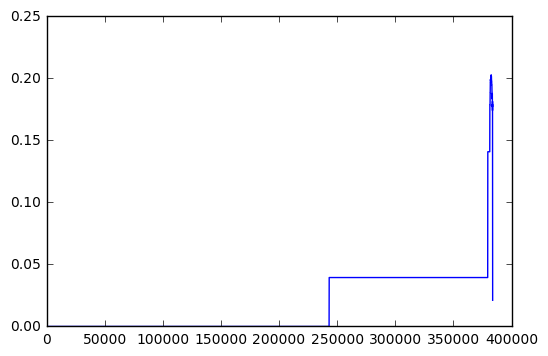

In [32]:
best_proba_val, best_mcc_val, y_pred_val = eval_mcc(dval.get_label(), roundn(bst.predict(dval), 100), show=True)

Check ratio of positive in predictions

In [14]:
y_pred_val.sum()/y_pred_val.size

0.0042449843256103627

Check ration of positive in true labels

In [15]:
label=dval.get_label()
label.sum()/label.size

0.0058163321146484535

In [16]:
best_proba_val

0.1

### Test

In [17]:
num_round=100
bst = xgb.train( params, dtrain, num_round)

In [19]:
dtest = xgb.DMatrix('/home/ubuntu/upload/test.svm')

In [20]:
y_pred_test=roundn(bst.predict(dtest), 100)

In [21]:
results=(y_pred_test >= best_proba_val).astype(int)

In [22]:
results.sum()/results.size

0.0046623098835225068

In [23]:
IDs=pandas.read_csv('/home/ubuntu/upload/Ids.txt')

In [24]:
IDs['Response']=results

In [25]:
IDs.head()

,Id,Response
0,1,0
1,2,0
2,3,0
3,5,0
4,8,0


In [26]:
IDs.to_csv('results.csv', index=False)